In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from itertools import chain

import os
import sys
import string
import re

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
import pickle

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/luuk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/luuk/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

First we have to read in the data, which consists of raw text files of the first 3 books of The Witcher series. We then preprocess the data. Which preprocessing techniques is the function `tokenize()` using?

In [3]:
def read(path):
    data = ""
    for file in os.listdir(path):
        if file.endswith(".txt"):
            with open(f"{path}{file}", 'r', encoding="utf8") as f:
                raw = f.read()
                data = f"{data}{raw}"
    return data

def tokenize(rawdata, sw):

    stop = sw
    lemmatizer = WordNetLemmatizer()
    sents = nltk.sent_tokenize(rawdata.lower())
    tokens = []
    for sent in sents:
        sent = re.sub(r'[^\w\s]', '', sent)
        tok = tuple([lemmatizer.lemmatize(i) for i in nltk.word_tokenize(sent.lower()) if i not in stop])
        tokens.append(tok)
    return list(chain.from_iterable(tokens)), tokens

gist_file = open("../data/gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    stopwordslist = content.split(",")  + ["dont", "don't", "did", "didnt", "didn't"] + stopwords.words('english') + list(string.punctuation)
finally:
    gist_file.close()

In [4]:
path = '../data/'
word_data, sent_data = tokenize(read(path), stopwordslist)

In [5]:
print(len(word_data), len(sent_data))

75617 17492


You always have to look at your data before you do something with it. Use the `.most_common()` method of the counter object to check what the 20 most frequent words in our data are.

In [7]:
c = Counter(word_data)
# TODO

[('geralt', 973), ('witcher', 671), ('ciri', 469), ('time', 412), ('eye', 410), ('hand', 378), ('head', 367), ('dandilion', 308), ('yennefer', 265), ('girl', 240), ('ill', 226), ('triss', 225), ('sword', 213), ('long', 213), ('elf', 209), ('face', 199), ('turned', 198), ('looked', 189), ('man', 188), ('ive', 186)]


Let's take a look at the Zipfian curve of our data.

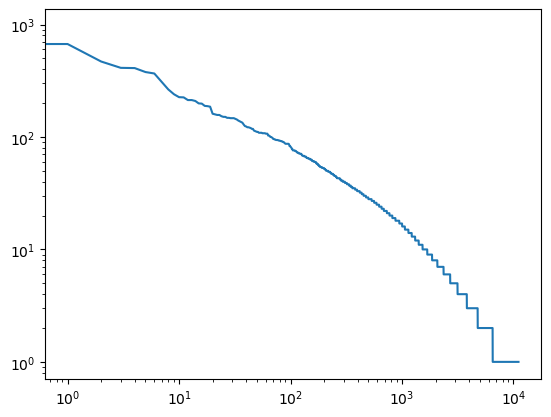

In [8]:
mostcommon = c.most_common()
plt.loglog([i for i, tup in enumerate(mostcommon)], [count for word, count in mostcommon])

Now we are going to build our matrix! We will be using a term-sentence matrix, where a word is represented in terms of how often it occurs in what sentences in the data. We construct a couple of helper datastructures that map each word/sentence to an index and vice versa, so we can look-up words easily later. Create the dictionary that maps words onto an index based on idx2word and do the same for the context.

In [9]:
# Some helper data structures that will help us find which words/sentences belong to which elements of the matrix
idx2word = list(set(word_data))
word2idx = {} #TODO

idx2context = list(set(sent_data))
context2id = {} # TODO

We initialize and empty matrix (only 0). Why do you think we use `dtype=np.float16` rather than `dtype=np.float64` ? Check how much memory the matrix is taking up with `sys.getsizeof()` (divide the result by `1048576` to get MB).

In [10]:
cooc_matrix = np.zeros((len(idx2word), len(idx2context)), dtype=np.float16) # words on rows, contexts on columns
print(cooc_matrix.shape)
print(f"Matrix memory: {} MB") #TODO

(11093, 14293)
Matrix memory: 302.41 MB


In this loop we construct the count matrix! We loop over the sentences of our data, and add 1 to the corresponding cell in the matrix. Complete the inner for loop, and make a variable that keeps track of the total count of the matrix (we will need it later).

In [11]:
total_count = #TODO
for i, context in enumerate(sent_data):
    context_idx = context2id[context]
    word_idx = [word2idx[word] for word in context]
    for j in word_idx:
        #TODO

Use `np.max()` to find out the highest count we recorded in the matrix. What percentage of entries is NOT zero? Calculate this with `np.count_nonzero()`, you can get the dimensions of the matrix as a tuple with `cooc_matrix.size`.

In [12]:
print(f"Total count: {total_count}")
print(f"Highest count: {}") # TODO
print(f"Percentage of zero elements: {}") # TODO

Total count: 75616
Highest count: 104.0
Percentage of zero elements: 0.04555596054648206


Let's make a PMI matrix out of the co-occurrence matrix. Can you reconstruct the math on the slides from the code? I made two versions of the function that does this for us, why do we want to use the second one over the first one? Why do we use the logarithm at the end?

In [13]:
def pmi(matrix, total_count):
    pmi_total = matrix / total_count # Eq 1
    pmi_words = (matrix.sum(axis=1) / total_count).reshape(-1, 1) # Eq 2
    pmi_contexts = (matrix.sum(axis=0) / total_count).reshape(-1, 1) # Eq 3

    #Eq 4
    denom = (pmi_words.T*pmi_contexts).T
    new_matrix = np.log(pmi_total / denom)

    #Eq 5
    new_matrix[new_matrix <= 0] = 0
    return new_matrix

def pmi_space(matrix, total_count):
    new_matrix = np.log(
        ((matrix) / total_count) /
        ((matrix.sum(axis=1) / total_count).reshape(-1, 1).T * (matrix.sum(axis=0) / total_count).reshape(-1, 1)).T
    )
    new_matrix[new_matrix <= 0] = 0
    new_matrix[np.isnan(new_matrix)] = 0
    return new_matrix

In [14]:
pmi_matrix = pmi_space(cooc_matrix, total_count)

/tmp/ipykernel_352605/1627137873.py:16: RuntimeWarning: invalid value encountered in true_divide
  ((matrix) / total_count) /
/tmp/ipykernel_352605/1627137873.py:15: RuntimeWarning: divide by zero encountered in log
  new_matrix = np.log(


We fixed one problem of the coocurrence matrix, but it is still really large! We can use Singular Value Decomposition to reduce the dimensionality of our matrix.

In [15]:
#Fitting the SVD class
svd =  TruncatedSVD(n_components = 300)
SVD_matrix = svd.fit_transform(pmi_matrix)

In [16]:
print(SVD_matrix.shape)
print(f"Matrix memory: {np.round(sys.getsizeof(SVD_matrix) / 1048576, 2)} MB") # Huge !

(11093, 300)
Matrix memory: 25.39 MB


Now that we have nice and neat dense matrix, we can compare vectors! Just for sanity we should check whether the cosine distance of a vector with itself is equal to `1`. Check this, but leave some room for numerical instability (`0.9999 = 1`). Similarly for the PMI, can you reconstruct the math for the cosine function from the code?

In [17]:
def cosine_distance(list_1, list_2):
  cos_sim = np.dot(list_1, list_2) / (np.linalg.norm(list_1) * np.linalg.norm(list_2))
  return cos_sim

for word in idx2word:
    assert # TODO

We can manually assess the quality of our vectors by looking at the top most similar words for a particular target word. This function below calculates the cosine similarity of every word in our matrix with `guess` (don't have to understand how this works).

In [18]:
def all_cosines(guess, words):
    # num_words x features @ features x 1 = num_words x 1
    numerator = words @ guess
    # words_matrix @ words_matrix.T --> the squares of the matrix are on the diagonal
    # we want to avoid computing all the non-diagonal elements somehow
    # we can achieve this with einstein summation:
    #   np.einsum('ij,jk') is the normal matrix product
    #   np.einsum('ij,ji') gives us the sum over all diagonal elements of the matrix product
    #   np.einsum('ij,ji->i') unforces the sum operation, so just returns the elements of the diagonal
    # dim: num_words x features \w features x num_words --> num_words x 1
    norms = np.sqrt(np.einsum('ij,ji->i', words, words.T))
    # elem-multiply by norm of guess, denominator --> (num_words x 1)
    denominator = norms * np.linalg.norm(guess, 2)
    cosines = numerator / denominator
    return np.round(cosines, 3)

def most_similar(n, matrix):
    sorted = np.argsort(matrix, axis=-1)
    return [(idx2word[i], matrix[i]) for i in sorted[len(sorted)-n:len(sorted)]]

Now we can look at our vectors in a very structured way. Can you find some interesting words for which our model gives counterintuitive of strange neighbours?

In [19]:
full = all_cosines(SVD_matrix[word2idx["ghoul"]], SVD_matrix)
print('SVD')
print(most_similar(10, full))
full = all_cosines(cooc_matrix[word2idx["ghoul"]], cooc_matrix)
print('COOC')
print(most_similar(10, full))
full = all_cosines(pmi_matrix[word2idx["ghoul"]], pmi_matrix)
print('PMI')
print(most_similar(10, full))

11093
[('silver', 0.349), ('aeschna', 0.35), ('graveirs', 0.356), ('kiki', 0.375), ('kikimora', 0.376), ('sensitive', 0.376), ('giant', 0.401), ('spraying', 0.402), ('werewolf', 0.403), ('vampire', 0.415), ('manticore', 0.424), ('annis', 0.431), ('scorpion', 0.44), ('ilyocoris', 0.45), ('cuach', 0.452), ('badraigh', 0.452), ('mal', 0.452), ('corpsedevouring', 0.478), ('chimera', 0.492), ('leshy', 0.496), ('graveir', 0.522), ('wyvern', 0.53), ('vypper', 0.563), ('fogler', 0.564), ('ghoul', 1.0)]


In [20]:
full = all_cosines(SVD_matrix[word2idx["castle"]], SVD_matrix)
print(most_similar(25, full))

11093
[('deciding', 0.492), ('baldhorn', 0.503), ('amusement', 0.505), ('clustered', 0.506), ('terrace', 0.506), ('drenching', 0.507), ('hagge', 0.512), ('cornice', 0.533), ('quake', 0.533), ('eyesockets', 0.545), ('cleaning', 0.549), ('roamed', 0.549), ('grooming', 0.549), ('refusal', 0.552), ('moat', 0.563), ('loop', 0.57), ('torpor', 0.577), ('reminds', 0.595), ('restless', 0.606), ('irritable', 0.606), ('eradicate', 0.645), ('blustered', 0.65), ('store', 0.699), ('citadel', 0.741), ('castle', 1.0)]


In [23]:
fileObj = open('witcher.mat', 'wb')
pickle.dump(SVD_matrix,fileObj)
fileObj.close()

fileObj = open('worddict.dic', 'wb')
pickle.dump(word2idx, fileObj)
fileObj.close()

fileObj = open('indices.list', 'wb')
pickle.dump(idx2word, fileObj)
fileObj.close()
